<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c620_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install autorch > log.txt

In [2]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
pd.options.display.max_rows = 999

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
df.head(3)

,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# 建立 f(case,input_wt,op) = output_wt

In [3]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
n_idx = [ [i,i+41,i+41*2,i+41*3] for i in range(41)]

  1%|          | 1/100 [00:00<01:25,  1.16it/s]

epoch:0 train_loss:0.0079 valid_loss:0.0013


 51%|█████     | 51/100 [00:30<00:29,  1.67it/s]

epoch:50 train_loss:0.0009 valid_loss:0.0010


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


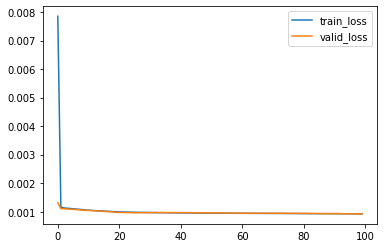

In [4]:
# train
c620_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=100,limit_y_range=True,normalize_idx_list=n_idx)
c620_f.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col+op_col),256),nn.Linear(256,256),nn.Linear(256,len(sp_col)),nn.Sigmoid())
c620_f.optimizer = Adam(c620_f.net.parameters(),lr=1e-3)
c620_f.train()

In [5]:
# test
x_test = c620_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c620_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
res = c620_f.show_metrics(wt_real,wt_pred)
res

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.969144,0.000412628,0.829948
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.963708,0.121416,0.63143
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.947983,0.0173115,0.257027
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.954333,0.0501947,1.92898
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,0.933609,0.0496833,5.11239
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,0.934322,0.000121583,4.35707
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,0.948377,0.0578377,2.14151
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,0.95546,1.3262e-07,2.28278
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,0.984508,5.95989e-09,1.94498


In [6]:
res.loc[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,0.996474,0.229971,0.494087


In [7]:
a = wt_pred[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']].head()
b = wt_real[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']].head()

In [8]:
b.columns = ['輸出端']
a.join(b)

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,輸出端
135-040,80.231851,80.000015
072-032,90.335513,90.000000
117-071,80.570109,79.999992
098-029,89.764097,90.000000
110-028,89.584497,90.000000


In [9]:
def F(case,input_wt,op):
  sp = c620_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

In [10]:
path = '/content/drive/MyDrive/台塑輕油案子/data/c620/模擬擴充資料0514.xlsx'
df_extend = pd.read_excel(path)
idx_extend = df_extend.iloc[0,6:].values
case_extend = df_extend.iloc[[5,6,7],6:].T
case_extend.columns = case_col
case_extend.index = idx_extend
case_extend.head(1)

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
2021-04-15,40.4029,0,74.55


In [11]:
wt_extend = df_extend.iloc[132:132+41,6:].T
wt_extend.columns = input_wt_col
wt_extend.index = idx_extend
wt_extend.head(1)

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
2021-04-15,0,0.0296863,0.719894,0.653423,0.183413,0.0765324,0.0159367,17.1791,0.00681777,0.0147861,0,0.0109084,37.2087,0.00727228,0.00856008,0.00856008,1.03071,7.28702,15.6964,6.67497,0.0124235,0.00965156,0.00234834,0.0118788,0.801822,0.420214,2.26218,0.236092,5.77757,0,0.922095,0.0415759,0.00115772,0.0254698,0.966693,0,1.11372,0.407516,0.174815,0,0


In [12]:
op_extend = df_extend.iloc[221:221+2,6:].T
op_extend.columns = op_col[-2:]
op_extend.index = idx_extend
op_extend.head(1)

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
2021-04-15,180.12,195.408


In [13]:
G = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')

In [14]:
op_pred = G.predict(case_extend.join(wt_extend))
op_pred = pd.DataFrame(op_pred,columns=op_col,index=idx_extend)
op_pred[op_col[-2:]] = op_extend
op_extend = op_pred
op_extend.head(1)

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
2021-04-15,0.862336,0.440623,0.799457,0.879027,0.872062,120.75872,12.440116,14.27548,180.12,195.408


In [15]:
df_extend = case_extend.join(wt_extend).join(op_extend).astype('float32')
df_extend.head(1)

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_

  2%|▏         | 1/42 [00:00<00:20,  2.03it/s]

epoch:0 train_loss:0.0036 valid_loss:0.0006


100%|██████████| 42/42 [00:20<00:00,  2.09it/s]


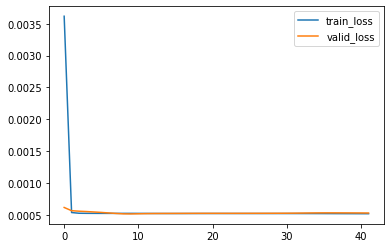

In [16]:
G = autorch.utils.PartBulider(df.append(df_extend),case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col),256),nn.Linear(256,256),nn.Linear(256,len(op_col)),nn.Sigmoid())
G.optimizer = Adam(G.net.parameters(),lr=1e-3)
G.train()

In [17]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.999837,2.40269e-10,0.00147084
Density_Vent Gas Production Rate and Composition,0.967225,8.20437e-07,0.150944
Density_Distillate Production Rate and Composition,0.927433,7.67319e-06,0.268852
Density_Sidedraw Production Rate and Composition,0.995279,5.32672e-09,0.00707878
Density_Bottoms Production Rate and Composition,0.997021,5.0122e-11,0.000669868
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.984366,2.06112,0.810303
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.987261,0.0152068,0.718755
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.985996,0.0234495,0.691062
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.894068,0.14218,0.179527
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.987234,0.00981386,0.0343378


In [18]:
cond = (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] >= 69) & (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] <= 71)
sample = df[cond].sample(10)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [19]:
sample[output_wt_col]

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [20]:
sample['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']

023-052    70.000008
008-079    70.000000
011-025    70.000000
033-027    70.000008
087-053    70.000008
042-075    69.999992
054-024    69.999992
041-020    69.999985
037-076    69.999992
134-097    69.999985
Name: Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%, dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'  == 70

In [21]:
!pip install optuna > log.txt

In [22]:
sample[input_wt_col]

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
023-052,0.0,0.023233,0.561320,0.512709,0.148361,0.067386,0.013974,14.842041,0.006360,0.012882,0.0,0.010175,39.232162,0.006783,0.007985,0.007985,0.945686,7.385044,16.132345,6.608339,0.011588,0.005576,0.002190,0.006505,0.911681,0.477680,2.419997,0.268579,6.181028,0.0,0.986957,0.032527,0.000929,0.021375,0.835475,0.0,0.960936,0.246275,0.105945,0.0,0.0
008-079,0.0,0.023001,0.555711,0.510174,0.150906,0.073088,0.015153,15.436262,0.007195,0.014312,0.0,0.011513,39.014656,0.007675,0.009034,0.009034,0.941701,7.328269,16.002665,6.547133,0.013112,0.005520,0.002478,0.006440,0.902570,0.472906,2.395812,0.265895,6.119257,0.0,0.977094,0.032202,0.000920,0.021161,0.827126,0.0,0.951332,0.243813,0.104886,0.0,0.0
011-025,0.0,0.023001,0.555711,0.510174,0.150906,0.073088,0.015153,1

In [23]:
sample[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
023-052,70.000008
008-079,70.000000
011-025,70.000000
033-027,70.000008
087-053,70.000008
042-075,69.999992
054-024,69.999992
041-020,69.999985
037-076,69.999992
134-097,69.999985


In [24]:
op_max = df.append(df_extend)[op_col].max().to_dict()
op_min = df.append(df_extend)[op_col].min().to_dict()

In [25]:
op_max

{'Density_Bottoms Production Rate and Composition': 0.8722013448663097,
 'Density_Distillate Production Rate and Composition': 0.8276968447728095,
 'Density_Feed Properties': 0.8646730162921348,
 'Density_Sidedraw Production Rate and Composition': 0.8816900667286587,
 'Density_Vent Gas Production Rate and Composition': 0.4596509754645822,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 181.28814697265625,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 195.40753173828125,
 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 15.352493044000001,
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 17.330535890000007,
 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 151.33982849999998}

In [26]:
op_min

{'Density_Bottoms Production Rate and Composition': 0.8718550196589577,
 'Density_Distillate Production Rate and Composition': 0.7715259991981224,
 'Density_Feed Properties': 0.8620919983765354,
 'Density_Sidedraw Production Rate and Composition': 0.8786906178745657,
 'Density_Vent Gas Production Rate and Composition': 0.42652801816569175,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 174.52383419999998,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 191.5879211,
 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 10.416381362000001,
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 12.03581238,
 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 97.02017975}

In [27]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl']

In [28]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端bz = sample[case_col]['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%'].values
                                                                                        
  輸出端bz = F(sample[case_col],sample[input_wt_col],op)['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'].values
  loss = np.mean((輸入端bz - 輸出端bz)**2)
  
  return loss

In [29]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=100)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-05-31 06:51:51,351] A new study created in memory with name: no-name-cf6e326e-bcf7-4131-a930-06bdc9db1e08
[I 2021-05-31 06:51:51,443] Trial 0 finished with value: 319.2648228209396 and parameters: {'Density_Feed Properties': 0.8626654970396991, 'Density_Vent Gas Production Rate and Composition': 0.44267007198972164, 'Density_Distillate Production Rate and Composition': 0.816234879492078, 'Density_Sidedraw Production Rate and Composition': 0.8802986688769584, 'Density_Bottoms Production Rate and Composition': 0.8719399437766148, 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 150.91310348836686, 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 13.610943367191652, 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 14.201818088499127, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 177.18132963905677, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 19

In [30]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
023-052,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
008-079,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
011-025,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
033-027,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
087-053,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
042-075,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
054-024,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
041-020,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
037-076,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687
134-097,0.862615,0.429355,0.771705,0.880196,0.87209,111.358253,10.480045,16.469797,177.090497,194.587687


In [31]:
# 看有沒有符合業主需要的70
a = sample[['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%']]
b = F(case,input_wt,op_opt)[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]
b.columns = ['優化結果']
a.join(b)

,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,優化結果
023-052,70.000008,70.010435
008-079,70.000000,70.216067
011-025,70.000000,70.178449
033-027,70.000008,70.178447
087-053,70.000008,66.382007
042-075,69.999992,70.063560
054-024,69.999992,70.461461
041-020,69.999985,70.008645
037-076,69.999992,70.183688
134-097,69.999985,66.353799


In [32]:
op_pred = G.predict(sample[case_col+input_wt_col])

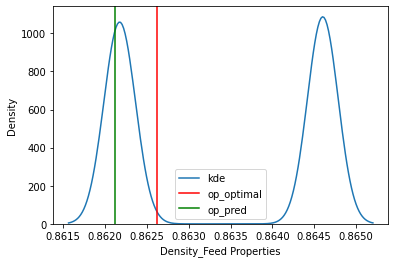

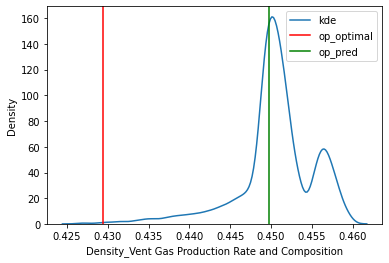

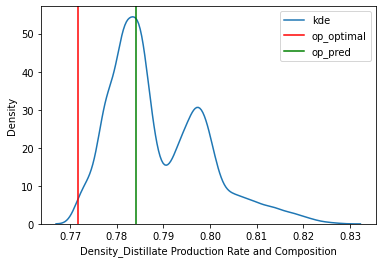

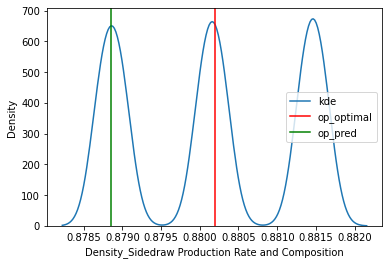

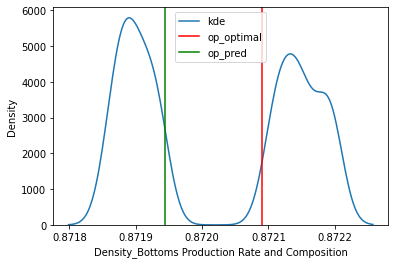

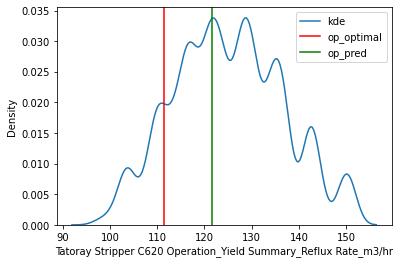

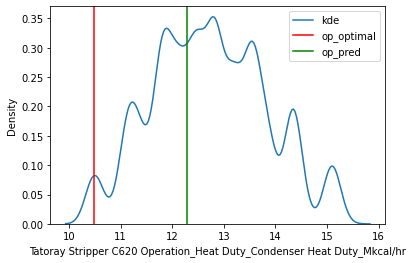

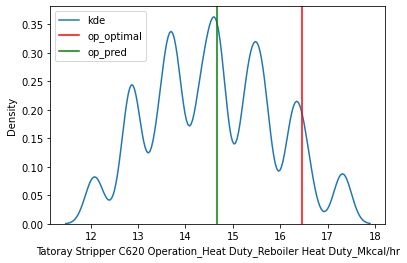

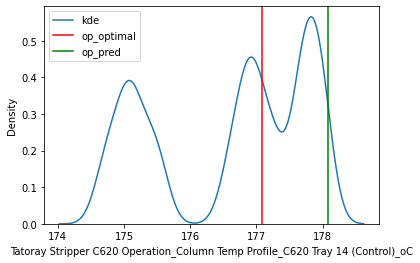

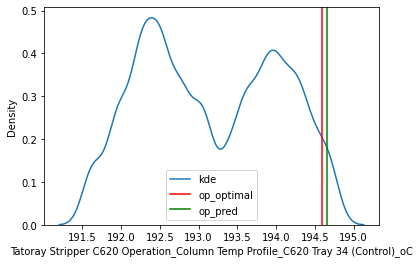

In [33]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [34]:
import joblib
G.shrink()
c620_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')
joblib.dump(c620_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl']